# Coursera Capstone Project
Tarek Zawi

#### Description of Problem

A potential client wants to open a health food store in the city of Toronto, but is unsure where the best location would be. Toronto is a bustling city, being the number one most populous city in Canada, and the fourth most populous in North America as a whole.There are already a number of health food stores present, so choosing a location where competition is less likely to be a factor is essential to maximize profits. The client is particularly interested in setting up shop in borough’s(districts) that contain the word Toronto, i.e.,Downtown Toronto, East Toronto, Central Toronto, West Toronto, and Toronto/York.


#### Data

Foursquare will be leveraged to solve the problem for its abundant and accurate location data. We will examine each neighborhood in the area of interest, and using the Foursquare API, we will explore nearby venues. In particular, we are interested in the presence of both health food stores and gyms-gym goers are generally health conscious individuals who would more likely frequent a health food store. This will be a good way to increase traffic to the store and help our chances of the store succeeding.

The data used will be two fold:
1) A table from Wikipedia listing the  borough and neighborhoods for the corresponding postal codes in Toronto, Canada.
2) A second table listing the geographical coordinates (latitude and longitude) for the different Postal Codes in Canada.


Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [36]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
#!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#install folium
!pip install folium
import folium

from sklearn.cluster import KMeans
from sklearn import datasets


print('Libraries imported.')

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Libraries imported.


Lets scrape the table with the needed Toronto geographical information from wikipedia and put it into a dataframe

In [2]:
url='https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=1011037969'
dfs=pd.read_html(url)
print(len(dfs))

3


In [3]:
df=dfs[0]

Lets preview the dataframe

In [4]:
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Only cells that have an assigned borough are of interest to us. We will drop the cells which do not have an assigned borough.
More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.
If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.

The data frame does not have the latititude and longitude coordinates for the neighborhoods, so we will import a csv with the necessary information. In order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood. 

In [5]:
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_966a994cd8994c5a91dc5f410f9bf19a = 'https://s3-api.us-geo.objectstorage.softlayer.net'
else:
    endpoint_966a994cd8994c5a91dc5f410f9bf19a = 'https://s3-api.us-geo.objectstorage.service.networklayer.com'

client_966a994cd8994c5a91dc5f410f9bf19a = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='Bk6Auea_evpxbrrhin2scuNdfyacisserkxBQo1pjF7_',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_966a994cd8994c5a91dc5f410f9bf19a)

body = client_966a994cd8994c5a91dc5f410f9bf19a.get_object(Bucket='segmentingandclusteringtorontodat-donotdelete-pr-vpkkm68rpotdkb',Key='Geospatial_Coordinates.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

dfcoor = pd.read_csv(body)
dfcoor.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


We will now join the original scraped table and our new table of latitude/longitude coordinates, matching the entires based on Postal Code

In [6]:
df_toronto=pd.merge(df,dfcoor, how='left', left_on='Postal Code', right_on='Postal Code')

In [7]:
df_toronto.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1A,Not assigned,Not assigned,NaN,NaN
1,M2A,Not assigned,Not assigned,NaN,NaN
2,M3A,North York,Parkwoods,43.753259,-79.329656
3,M4A,North York,Victoria Village,43.725882,-79.315572
4,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636


We will drop any rows which are missing latitude and longitude values.

In [8]:
df_toronto=df_toronto.dropna(axis=0,how='any')

We will now confirm the shape of our new data frame.

In [9]:
df_toronto.shape

(103, 5)

We will now look at only look at those borough's(districts) that contain the word Toronto, i.e.,Downtown Toronto, East Toronto, Central Toronto, West Toronto, and Toronto/York. We will filter our dataframe using the following code.

In [10]:
toronto_data=df_toronto[df_toronto['Borough'].str.contains('Toronto')].reset_index(drop=True)
toronto_data.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


# Foursquare

Now that our data is ready to go, we can begin using the Foursquare API to explore each neighborhood in our dataset. First, we will use geopy library to get the latitude and longitude values of Toronto. In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent toronto_explorer, as shown below

In [11]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


We will now visualize the neighborhoods in Toronto to get an idea of what our data set looks like physically on the map. We will do this using folium, which is a python library that can be used to create interactive leaflet maps.

In [12]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

When we explore the venues near each neighborhood so we can segment them, we are going to begin by returning the top 100 venues nearby, within a 500 meter radius. We will then later filter this data to only display results regarding nearby gyms and health food stores. Foursquare credentials necessary to use the API are defined below.

In [13]:
CLIENT_ID = 'UTLNKAN013DNWTEMMZ2KACGTZH5CYFB2LH3YU5TAHWWAEQRB' # your Foursquare ID
CLIENT_SECRET = 'YTFSO2AB01OTHKUKJE3AFY5GJU4CANSJRSQ5W2KJXNJPBEM4' # your Foursquare Secret
ACCESS_TOKEN = 'AGVU4OHRDGGVYTKZ5RY3TSDPGCXZFM0FTZHGTKQZD1JQ1TL2' # your FourSquare Access Token
VERSION ='20212104' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Let's explore the first neighborhood in our dataframe- We will get the neighborhood's name and latitude and longitude values.

In [14]:
neighborhood_latitude = toronto_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_data.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Regent Park, Harbourfront are 43.6542599, -79.3606359.


Now, let's get the top 100 venues that are in Regent Park, Harbourfront within a radius of 500 meters.

In [15]:
radius=500
LIMIT=100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

Now we will send a GET request to examine the results. The results will be in the format of a json file, which will we need to convert into a dataframe.


In [16]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '608848e375caea17dcc225f1'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Corktown',
  'headerFullLocation': 'Corktown, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 45,
  'suggestedBounds': {'ne': {'lat': 43.6587599045, 'lng': -79.3544279001486},
   'sw': {'lat': 43.6497598955, 'lng': -79.36684389985142}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '54ea41ad498e9a11e9e13308',
       'name': 'Roselle Desserts',
       'location': {'address': '362 King St E',
        'crossStreet': 'Trinity St',
        'lat': 43.653446723052674,
        'lng': -79.3620167174383,
        'labeledLatLngs': [{'label': 'display',
 

All the information is in the items key. Before we proceed, we will use a function  get_category_type to extract the category row of the venue.

In [17]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a pandas dataframe.

In [18]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng
0,Roselle Desserts,Bakery,43.653447,-79.362017
1,Tandem Coffee,Coffee Shop,43.653559,-79.361809
2,Cooper Koo Family YMCA,Distribution Center,43.653249,-79.358008
3,Body Blitz Spa East,Spa,43.654735,-79.359874
4,Corktown Common,Park,43.655618,-79.356211


And how many venues were returned by Foursquare?

In [20]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

45 venues were returned by Foursquare.


We will now create a function to repeat the same process for all the neighborhoods in the boroughs containing the word Toronto

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now, we create code to run the above function on each neighborhood and create a new dataframe called _torontovenues.

In [23]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Runnymede, The Junction, Weston-Pellam Park, Carlton Village
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harb

Let's check the size of the resulting dataframe

In [25]:
print(toronto_venues.shape)

(1611, 7)


Let's check how many venues were returned for each neighborhood

In [26]:
toronto_venues.groupby('Neighborhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,61,61,61,61,61,61
"Brockton, Parkdale Village, Exhibition Place",22,22,22,22,22,22
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",17,17,17,17,17,17
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,61,61,61,61,61,61
Christie,16,16,16,16,16,16
Church and Wellesley,77,77,77,77,77,77
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,33,33,33,33,33,33


Let us convert the dataframe into fully numerical variables, so there are no categorical variables. This will be important when we analyze the data later on.

In [29]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]



,Neighborhood,Yoga Studio,Adult Boutique,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop
0,Berczy Park,0.000000,0.0,0.0000,0.0000,0.000,0.0000,0.000,0.0,0.0,0.0,0.016393,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.016393,0.049180,0.000000,0.000000,0.0,0.016393,0.016393,0.0,0.032787,0.0,0.0,0.016393,0.0,0.0000,0.0,0.0,0.0,0.016393,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.016393,0.0,0.0,0.0,0.032787,0.0,0.0,0.0,0.000000,0.016393,0.04918,0.098361,0.0,0.0,0.0,0.0,0.0,0.0,0.016393,0.000000,0.016393,0.000000,0.0,0.0,0.016393,0.0,0.0,0.0,0.0,0.016393,0.0,0.0,0.016393,0.000000,0.0,0.0,0.0,0.000000,0.0,0.016393,0.0,0.0,0.0,0.0,0.000000,0.032787,0.000000,0.0,0.0,0.016393,0.0,0.0,0.0,0.0,0.0,0.016393,0.016393,0.000000,0.0,0.0,0.000000,

# Methodology

In this project we are interested in the number of both health food stores and gyms in our geographical area of interest, particularly those with a low number of health food stores and a high number of gyms. We are analyzing the venues near each neighborhood within a 500 meter radius to find the neighborhoods which meet our needs.

In the first step, we have collected the required data about the location of each neighborhood and the type(category) of the venues nearby.

In the second step, we will isolate the data we need from the data frame regarding our venues of interest, and determine the frequency of those venues.

In the third and final step, we will use a machine learning algorithm known as "K-Means Clustering" to analyze the data and create clusters of locations that meet our requirements, as previously discussed with the stakeholders interested in this project. We will present a map of those clusters to better visualize the data and explore the best location to satisfy our project goals.

# Analysis

Let us change the dataframe so it displays the frequency of venues around each neighborhood, to better helps us understand the data.


In [30]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Adult Boutique,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop
0,Berczy Park,0.000000,0.0,0.0000,0.0000,0.000,0.0000,0.000,0.0,0.0,0.0,0.016393,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.016393,0.049180,0.000000,0.000000,0.0,0.016393,0.016393,0.0,0.032787,0.0,0.0,0.016393,0.0,0.0000,0.0,0.0,0.0,0.016393,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.016393,0.0,0.0,0.0,0.032787,0.0,0.0,0.0,0.000000,0.016393,0.04918,0.098361,0.0,0.0,0.0,0.0,0.0,0.0,0.016393,0.000000,0.016393,0.000000,0.0,0.0,0.016393,0.0,0.0,0.0,0.0,0.016393,0.0,0.0,0.016393,0.000000,0.0,0.0,0.0,0.000000,0.0,0.016393,0.0,0.0,0.0,0.0,0.000000,0.032787,0.000000,0.0,0.0,0.016393,0.0,0.0,0.0,0.0,0.0,0.016393,0.016393,0.000000,0.0,0.0,0.000000,

Let us get only the data of interest from our current data set. We will filter our data to display only the neighborhood name and the frequency of health food stores and gyms around that neighborhood.

In [44]:
df_gymhealth=toronto_grouped[['Neighborhood','Health Food Store','Gym']]
df_gymhealth.head()

,Neighborhood,Health Food Store,Gym
0,Berczy Park,0.0,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.0,0.045455
2,"Business reply mail Processing Centre, South C...",0.0,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.0,0.000000
4,Central Bay Street,0.0,0.000000


Before we can perform K-Means clustering, we must choose the optimal value of K. We will do this using the elbow method on our gym/health food store frequency dataframe

In [45]:
toronto_clustering=df_gymhealth.drop(['Neighborhood'],axis=1)
distortions = []
K = range(1,40)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(toronto_clustering)
    distortions.append(kmeanModel.inertia_)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:6: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:6: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (12). Possibly due to duplicate points in X.
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:6: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (13). Possibly due to duplicate points in X.
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:6: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (14). Possibly due to duplicate points in X.
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:6: ConvergenceWarning: Number of distinct clusters (10) found smal

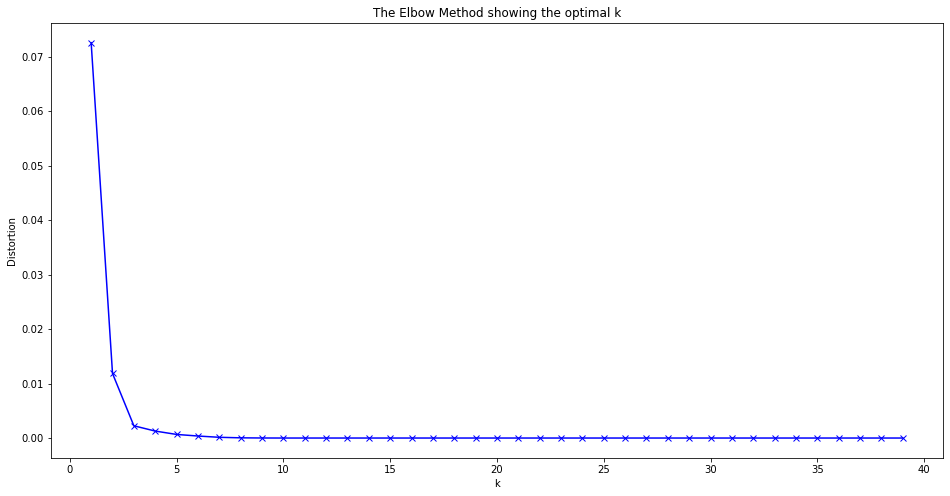

In [37]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Based on the elbow method, the best value for K is K=3. Now we will perform K means clustering with this value of K=3 to segment the neighborhood into 3 clusters.

In [46]:
# set number of clusters
kclusters = 3



# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 0, 0, 0, 0, 0, 2, 2, 0], dtype=int32)

Let's create a new dataframe that includes the assigned cluster number as well as the borough name, neighborhood name as well as latitude and longitude, and tge frequency of health food stores and gyms. We will do this by merging two of our existing dataframes, df_gymhealth and df_toronto.

In [47]:
df_toronto.rename(columns={'Neighbourhood':'Neighborhood'},inplace=True)
# add clustering labels
df_gymhealth.insert(0, 'cluster number', kmeans.labels_)

df_labeledclusters=pd.merge(df_gymhealth,df_toronto, how='left',left_on='Neighborhood',right_on='Neighborhood')

df_labeledclusters.head()

,cluster number,Neighborhood,Health Food Store,Gym,Postal Code,Borough,Latitude,Longitude
0,0,Berczy Park,0.0,0.000000,M5E,Downtown Toronto,43.644771,-79.373306
1,2,"Brockton, Parkdale Village, Exhibition Place",0.0,0.045455,M6K,West Toronto,43.636847,-79.428191
2,0,"Business reply mail Processing Centre, South C...",0.0,0.000000,M7Y,East Toronto,43.662744,-79.321558
3,0,"CN Tower, King and Spadina, Railway Lands, Har...",0.0,0.000000,M5V,Downtown Toronto,43.628947,-79.394420
4,0,Central Bay Street,0.0,0.000000,M5G,Downtown Toronto,43.657952,-79.387383


Finally, let's visualize the resulting clusters once again using folium.

In [48]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_labeledclusters['Latitude'],df_labeledclusters['Longitude'], df_labeledclusters['Neighborhood'], df_labeledclusters['cluster number']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Examine Clusters

Cluster 1

Cluster 1 can be seen to contain neighborhoods which have few or zero health food stores and gyms. This cluster is red on the map.

In [49]:
df_labeledclusters.loc[df_labeledclusters['cluster number']==0]

,cluster number,Neighborhood,Health Food Store,Gym,Postal Code,Borough,Latitude,Longitude
0,0,Berczy Park,0.0,0.00,M5E,Downtown Toronto,43.644771,-79.373306
2,0,"Business reply mail Processing Centre, South C...",0.0,0.00,M7Y,East Toronto,43.662744,-79.321558
3,0,"CN Tower, King and Spadina, Railway Lands, Har...",0.0,0.00,M5V,Downtown Toronto,43.628947,-79.394420
4,0,Central Bay Street,0.0,0.00,M5G,Downtown Toronto,43.657952,-79.387383
5,0,Christie,0.0,0.00,M6G,Downtown Toronto,43.669542,-79.422564
6,0,Church and Wellesley,0.0,0.00,M4Y,Downtown Toronto,43.665860,-79.383160
9,0,Davisville North,0.0,0.00,M4P,Central Toronto,43.712751,-79.390197
10,0,"Dufferin, Dovercourt Village",0.0,0.00,M6H,West Toronto,43.669005,-79.442259
12,0,"Forest Hill North & West, Forest Hill Road Park",0.0,0.00,M5P,Central Toronto,43.696948,-79.411307
13,0,"Garden District, Ryerson",0.0,0.01,M5B,Downtown Toronto,43.657162,-79.378937


Cluster 2

Cluster 2 only contains a single neighborhood which has neaby healthfood stores but no gyms. This cluster is purple on the map.

In [50]:
df_labeledclusters.loc[df_labeledclusters['cluster number']==1]

,cluster number,Neighborhood,Health Food Store,Gym,Postal Code,Borough,Latitude,Longitude
36,1,The Beaches,0.25,0.0,M4E,East Toronto,43.676357,-79.293031


Cluster 3

Cluster 3 contains neighborhoods which have no or few healthfood stores and several gyms nearby. This cluster is green on the map.

In [51]:
df_labeledclusters.loc[df_labeledclusters['cluster number']==2]

,cluster number,Neighborhood,Health Food Store,Gym,Postal Code,Borough,Latitude,Longitude
1,2,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.045455,M6K,West Toronto,43.636847,-79.428191
7,2,"Commerce Court, Victoria Hotel",0.000000,0.040000,M5L,Downtown Toronto,43.648198,-79.379817
8,2,Davisville,0.000000,0.060606,M4S,Central Toronto,43.704324,-79.388790
11,2,"First Canadian Place, Underground city",0.000000,0.040000,M5X,Downtown Toronto,43.648429,-79.382280
16,2,"India Bazaar, The Beaches West",0.000000,0.045455,M4L,East Toronto,43.668999,-79.315572
23,2,"Queen's Park, Ontario Provincial Government",0.000000,0.032258,M7A,Downtown Toronto,43.662301,-79.389494
25,2,"Richmond, Adelaide, King",0.000000,0.032258,M5H,Downtown Toronto,43.650571,-79.384568
28,2,"Runnymede, Swansea",0.027778,0.027778,M6S,West Toronto,43.651571,-79.484450
30,2,St. James Town,0.000000,0.024390,M5C,Downtown Toronto,43.651494,-79.375418
32,2,Stn A PO Boxes,0.000000,0.020408,M5W,Downtown Toronto,43.646435,-79.374846


Filtering the cluser 3 results to display the results in descending order of gym frequency:

In [53]:
df_cluster2=df_labeledclusters.loc[df_labeledclusters['cluster number']==2]
df_cluster2.sort_values('Gym',ascending=False)


,cluster number,Neighborhood,Health Food Store,Gym,Postal Code,Borough,Latitude,Longitude
8,2,Davisville,0.000000,0.060606,M4S,Central Toronto,43.704324,-79.388790
1,2,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.045455,M6K,West Toronto,43.636847,-79.428191
16,2,"India Bazaar, The Beaches West",0.000000,0.045455,M4L,East Toronto,43.668999,-79.315572
7,2,"Commerce Court, Victoria Hotel",0.000000,0.040000,M5L,Downtown Toronto,43.648198,-79.379817
11,2,"First Canadian Place, Underground city",0.000000,0.040000,M5X,Downtown Toronto,43.648429,-79.382280
23,2,"Queen's Park, Ontario Provincial Government",0.000000,0.032258,M7A,Downtown Toronto,43.662301,-79.389494
25,2,"Richmond, Adelaide, King",0.000000,0.032258,M5H,Downtown Toronto,43.650571,-79.384568
28,2,"Runnymede, Swansea",0.027778,0.027778,M6S,West Toronto,43.651571,-79.484450
30,2,St. James Town,0.000000,0.024390,M5C,Downtown Toronto,43.651494,-79.375418
32,2,Stn A PO Boxes,0.000000,0.020408,M5W,Downtown Toronto,43.646435,-79.374846


# Results and Discussion

This project had the goal of finding the ideal neighborhood in the city of Toronto, Canada in which to open a health food store. We began by looking at all the neighborhoods in Toronto, and then specifically focused our attention on those borough's(districts) which contain the word "toronto", meaning Central Toronto, West Toronto, East Toronto, Downtown Toronto and Toronto/York. We began by retrieving the top 100 nearby venues in a 500 meter radius for the neighborhoods in our area of interest and then filtered down those results by focusing only on the frequency of two specific venues near each neighborhood- health food stores and gyms. Those neighborhoods of interest were clustered using machine learning techniques in order to identify the best location candidates.

Based on the results from the clustering analysis, the best neighborhoods for the stakeholders to open a health food store in would be Daisville, followed by Brockton, Parkdale Village, Exhibition Place and lastly, India Bazaar, The Beaches West. These are the top 3 neighborhoods from our results that contain no other healthfood stores and a high frequency of gyms. This is ideal and meets our needs.

The analysis performed has provided a good starting point to identify potential locations to open a health food store in Toronto, Canada. However there are drawbacks with the analysis- the clustering is based solely on data obtained from the Foursquare API, which has substantial location data but is not absolutely comprehensive. There could be other suitable locations that were not included in our analysis. The analysis was also limited in it's scope- there are certainly other factors to consider when choosing a location to open a health food store. One such would be income of the residents in the area. Those individuals with lower income may not have the means to buy healthy, high quality food. Even though the analysis can be improved it has indeed provided us valuable information and a solid foundation to determine the best location for the stakeholders.

# Conclusion

This project provided the opprtunity to work on a 'real world' data science problem, something an aspiring data scientist may encounter in their day to day work. Using information from Wikipedia, geospatial data about Toronto,Canada and the Foursquare API, the city of Toronto was explored using several python libraries and tools with the goal of solving a business problem, namely: where is the ideal location to open up a new health food store? Folium was used as a geographical visualization tool, and machine learning techniques were used to analyze the data and produce meaningful information to answer our question.

The analysis performed has areas it can be improved- a larger volume of data that includes information on other factors, as previously mentioned, would aid in making a more informed decision. The work done in this project can be applied to a number of other scenarious as well. For example, where should a new restauarant be opened? Or a spa? Or any other number of possible venues. It serves as a branching point to gain insight into a multitude of more complex problems.